# 패키지 설치

In [0]:
!pip install fastai==0.7
!pip install scikit-learn==0.19.1

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 496.4MB 20kB/s 
     |████████████████████████████████| 1.5MB 42.7MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2666640 sha256=d414b4e811a1bdd1ece00d1cf1d88983bc8ab7b479d027091d185da26f327496
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 12.4MB 2.8MB/s 
ERROR: yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatib

# 필요한 패키지 import

In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
from pathlib import Path

import pandas as pd
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 전처리

## 데이터를 Pandas DataFrame으로 불러오기

In [0]:
PATH = Path('/content')
df = pd.read_csv(PATH/'Train.csv', low_memory=False, parse_dates=['saledate'])

## 날짜 데이터로부터 추가적인 정보 생성및 삽입

In [0]:
add_datepart(df, 'saledate')

## 범주형 데이터에 대한 속성 추가

In [0]:
train_cats(df)

## 'SalePrice'를 레이블로, 훈련/정답 데이터 분할

In [0]:
X, y, nas = proc_df(df, 'SalePrice')

## 레이블 값에 LOG 취해주기

In [0]:
y = np.log(y)

# 랜덤포레스트 모델 훈련의 첫 시도 

In [0]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### 훈련된 모델로 예측 값 구해보기

In [0]:
# 배열 전체에 대해서
model.predict(X)

array([11.0797 , 10.92821,  9.24663, ...,  9.33191,  9.08601,  9.04115])

In [0]:
# 하나의 값에 대해서
model.predict(X[:1])

array([11.0797])

### 훈련된 모델의 성능 평가

In [0]:
print(model.score(X, y))

0.9829824841347204


# 훈련-검증 데이터셋 분리 작업

In [0]:
def split_valid_set(entire_df, num_train): 
   return entire_df[:num_train].copy(), entire_df[num_train:].copy()

In [0]:
num_valid            = 12000  
num_train            = len(X) - num_valid
X_train, X_valid     = split_valid_set(X, num_train)
y_train, y_valid     = split_valid_set(y, num_train)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(389125, 66) (389125,) (12000, 66) (12000,)


## 모델 성능 평가 방식에 RMSE도 추가

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(model):
   scores = [rmse(model.predict(X_train), y_train), 
            rmse(model.predict(X_valid), y_valid),
            model.score(X_train, y_train),
            model.score(X_valid, y_valid)]
   print(scores)

### 모델을 훈련 데이터셋에 대하여 다시 학습시켜보기

In [0]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

[0.09056738446238667, 0.24892851918014958, 0.9828573295029892, 0.8893383133600861]


### proc_df를 이용해서, 데이터셋의 부분집합 만들기

In [0]:
X_sub, y_sub, nas = proc_df(df, 'SalePrice', subset=30000, na_dict=nas)
y_sub = np.log(y_sub)
X_train, _ = split_valid_set(X_sub, 20000)
y_train, _ = split_valid_set(y_sub, 20000)

model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

print_score(model)

[0.03810772727516497, 0.3893719062076929, 0.9968392244558948, 0.729244554162841]


### %time 명령어로 훈련에 걸리는 시간 측정

In [0]:
%time model.fit(X_train, y_train)

CPU times: user 41.6 s, sys: 178 ms, total: 41.8 s
Wall time: 24.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

# 랜덤포레스트의 단일 결정 나무 분석

## 하나의 결정 나무로 만들어진 랜덤포레스트 모델 훈련시키기

In [0]:
model = RandomForestRegressor(n_estimators=1, max_depth=3, 
                               bootstrap=False, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

[0.5242958275022648, 0.5829386872895965, 0.4016981268968718, 0.39313270785972987]


## 학습된 모델의 첫 번째 결정나무를 시각화

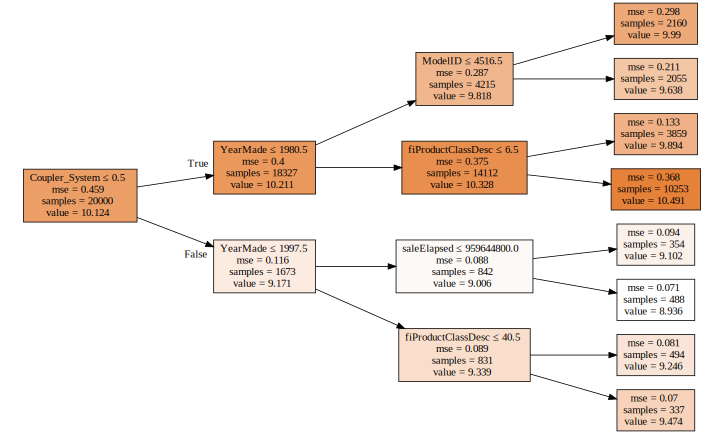

In [0]:
draw_tree(model.estimators_[0], X_sub, precision=3)

## 결정 나무 개수를 늘려가면서 성능 평가 해보기

### 결정나무 1~10개마다 R2 점수 비교

[0.11091636480144376, 0.3530297199352525, 0.9726632912391437, 0.7774280092285933]


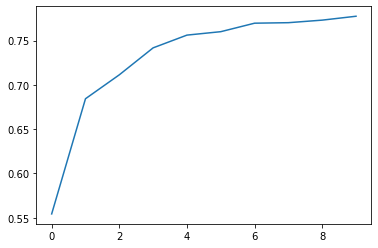

In [0]:
model = RandomForestRegressor(n_estimators=10, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

predictions = np.stack([tree.predict(X_valid) for tree in model.estimators_])

r2_scores = []
for i in range(10):
    mean = np.mean(predictions[:i+1], axis=0)
    r2_scores.append(metrics.r2_score(y_valid, mean))
plt.plot(r2_scores)


### OOB 점수도 추가

In [0]:
def print_score(model, X_train, y_train, X_valid, y_valid):
   res = [rmse(model.predict(X_train), y_train), 
         rmse(model.predict(X_valid), y_valid),
         model.score(X_train, y_train),
         model.score(X_valid, y_valid)]
   if hasattr(model, 'oob_score_'): res.append(model.oob_score_)
   print(res)

### 40개의 결정나무로 구성된 랜덤포레스트 모델

In [0]:
model = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

[0.09711440759291283, 0.33280789796631527, 0.9790433287060119, 0.8021959305190379, 0.8506005583264215]


# set_rf_ssamples

## 설정 초기화

In [0]:
X, y, nas = proc_df(df, 'SalePrice')
y = np.log(y)

In [0]:
num_valid            = 12000  
num_train            = len(X) - num_valid
X_train, X_valid     = split_valid_set(X, num_train)
y_train, y_valid     = split_valid_set(y, num_train)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(389125, 66) (389125,) (12000, 66) (12000,)


## set_rf_samples

In [0]:
set_rf_samples(20000)

model = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

[0.24061041639386702, 0.2781793063050742, 0.8790060443143941, 0.8618033187974511, 0.8664181215817088]


## reset_rf_samples로 rf_samples 기능 무효화

In [0]:
reset_rf_samples()

# min_samples_leaf 개수에 따른 성능 평가

In [0]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                               n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)


[0.11524925510240323, 0.23556419056350789, 0.9722405357420335, 0.9009016286250457, 0.9084082713153743]


In [0]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=5,
                               n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)


[0.14067562310219447, 0.23480331977703076, 0.9586407627341333, 0.9015407689216199, 0.9069429717521003]


# max_features 값에 따른 성능 평가

In [0]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=5,
                               max_features=0.5, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

[0.1444677346354844, 0.22858092615829567, 0.9563809149486255, 0.9066900514250277, 0.9103562178010168]


## set_rf_samples도 적용 해보기

In [0]:
set_rf_samples(50000)
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=5,
                               max_features=0.5, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

[0.2153300483292211, 0.2511616683551171, 0.9030954650183728, 0.8873439052010169, 0.8902213010610384]


# 학습된 결과의 해석

In [0]:
def get_predictions(tree): 
    return tree.predict(X_valid)

In [0]:
predictions = np.stack(parallel_trees(model, get_predictions))

In [0]:
predictions

array([[10.49117, 10.49117,  9.89433, ..., 10.49117, 10.49117, 10.49117]])

In [0]:
predictions.shape

(40, 12000)

In [0]:
_, tmp_valid = split_valid_set(df, num_train)
x = tmp_valid.copy()
x['SalePrice'] = np.log(x['SalePrice'])
x['PredictionStd'] = np.std(predictions, axis=0)
x['PredictionMean'] = np.mean(predictions, axis=0)

In [0]:
x.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [0]:
fields = ['Enclosure', 'SalePrice', 'PredictionMean', 'PredictionStd']
enc_summary = x[fields].groupby('Enclosure', as_index=False).mean()
print(enc_summary)

             Enclosure  SalePrice  PredictionMean  PredictionStd
0                EROPS   9.849178        9.836926       0.243940
1             EROPS AC        NaN             NaN            NaN
2           EROPS w AC  10.623971       10.575709       0.240357
3              NO ROPS        NaN             NaN            NaN
4  None or Unspecified        NaN             NaN            NaN
5                OROPS   9.682064        9.687330       0.196196


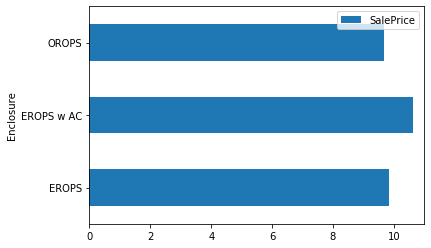

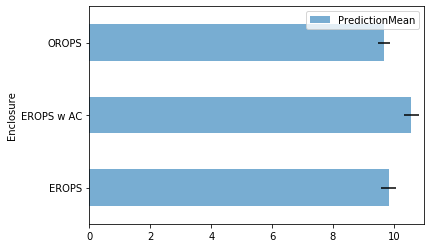

In [0]:
enc_summary = enc_summary[~pd.isnull(enc_summary.SalePrice)]
enc_summary.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))
enc_summary.plot('Enclosure', 'PredictionMean', 'barh', xerr='PredictionStd', alpha=0.6, xlim=(0,11))

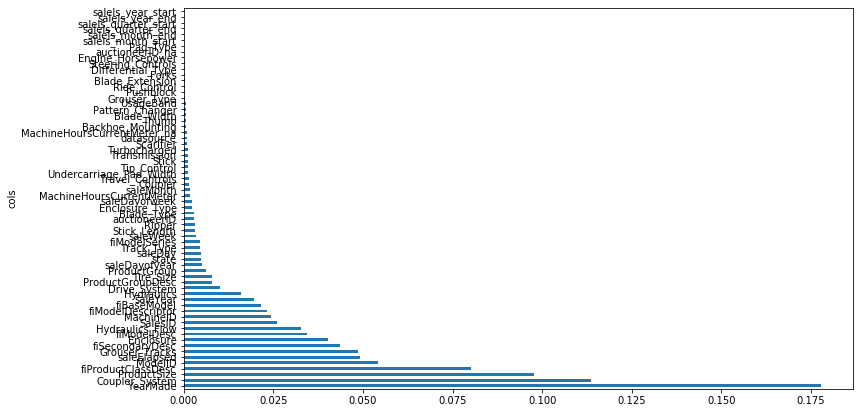

In [0]:
feature_importance = rf_feat_importance(model, X_train)
feature_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [0]:
(X_train.shape, y_train.shape)

((389125, 66), (389125,))

In [0]:
(X_valid.shape, y_valid.shape)

((12000, 66), (12000,))

In [0]:
threshold = 0.005
to_keep = feature_importance.imp > threshold
X_keep = X[feature_importance[to_keep].cols].copy()

print(str(X.shape) + ", " + str(X_keep.shape))

num_valid            = 12000  
num_train            = len(X_keep) - num_valid
X_train, X_valid = split_valid_set(X_keep, num_train)
y_train, y_valid = split_valid_set(y, num_train)

model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                               max_features=0.5, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

(401125, 66), (401125, 22)


TypeError: ignored

In [0]:
X2, y2, _ = proc_df(df, 'SalePrice', max_n_cat=7)
y2 = np.log(y2)

num_valid = 12000
num_train = len(X2) - num_valid
X_train2, X_valid2 = split_valid_set(X2, num_train)
y_train2, y_valid2 = split_valid_set(y2, num_train)
 
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                           max_features=0.5, n_jobs=-1, oob_score=True)
model.fit(X_train2, y_train2)
print_score(model, X_train2, y_train2, X_valid2, y_valid2)

[0.20831126741940673, 0.254260887615141, 0.909309802295604, 0.884546503104868, 0.8918445830014952]


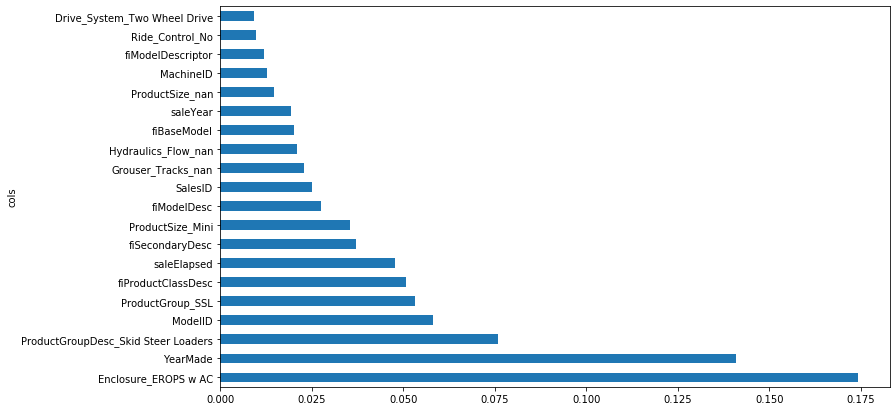

In [0]:
fi = rf_feat_importance(model, X2)
fi = fi[:20]
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

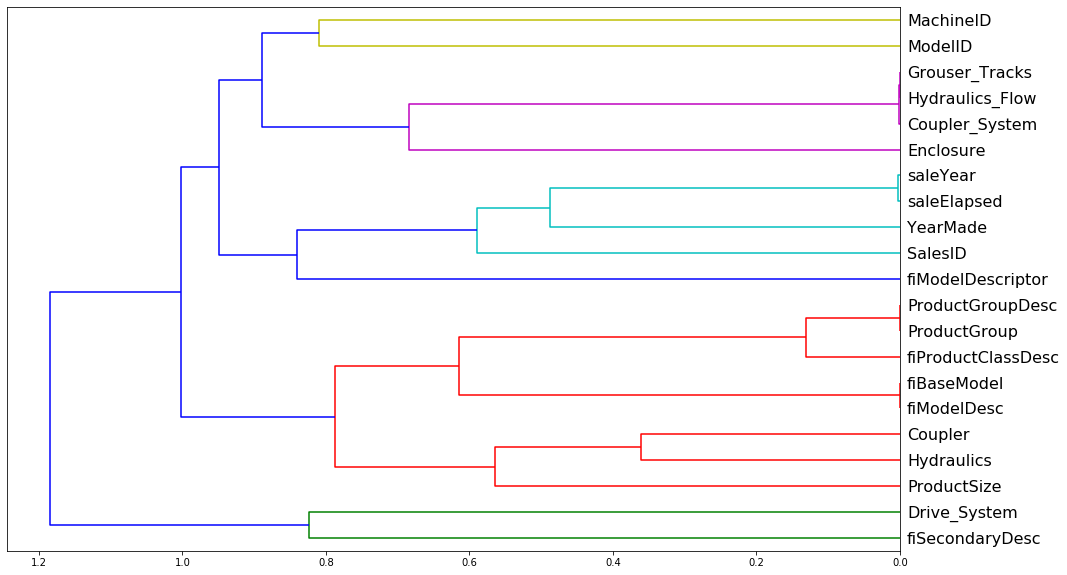

In [0]:
from scipy.cluster import hierarchy
from scipy.stats import spearmanr

corr = np.round(spearmanr(X_keep).correlation, 4)
corr_condensed = hierarchy.distance.squareform(1-corr)
linkage = hierarchy.linkage(corr_condensed, method='average')

fig = plt.figure(figsize=(16,10))
dendrogram = hierarchy.dendrogram(linkage, labels=X_keep.columns, 
                                  orientation='left', leaf_font_size=16)
plt.show()

In [0]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
X_keep.drop(to_drop, axis=1, inplace=True)

model = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, 
                               max_features=0.5, n_jobs=-1, oob_score=True)

X_train, X_valid = split_valid_set(X_keep, num_train)

model.fit(X_train, y_train)
print(model.oob_score_) 

0.8882825952040463


In [0]:
set_rf_samples(50000)
model = RandomForestRegressor(n_estimators=160, max_features=0.5, 
                              n_jobs=-1, oob_score=True)

model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid) 

[0.1924492558107164, 0.2409622584347453, 0.9225953059873923, 0.8963078154884113, 0.8999380747311208]


In [0]:
reset_rf_samples()
model = RandomForestRegressor(n_estimators=160, max_features=0.5, 
                              n_jobs=-1, oob_score=True)

model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid) 

[0.07557393979222281, 0.226703583065468, 0.9880634463968505, 0.9082164730042194, 0.9126379810408702]


In [0]:
set_rf_samples(80000)
model = RandomForestRegressor(n_estimators=200, max_features=0.5, 
                              n_jobs=-1, oob_score=True)

model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid) 

[0.17397019602392205, 0.23587012308425945, 0.9367465043063529, 0.9006440589032713, 0.9046611441998335]


In [0]:
reset_rf_samples()
model = RandomForestRegressor(n_estimators=100, max_features=0.5, 
                              n_jobs=-1, oob_score=True)

model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid) 

[0.07724360172674587, 0.22864033212199278, 0.987530189377568, 0.9066415444229914, 0.9093497383366543]


In [0]:
model

NameError: ignored

In [0]:
!pip install treeinterpreter

In [0]:
from treeinterpreter import treeinterpreter as ti

row = X_valid.values[None, 0]
prediction, bias, contributions = ti.predict(model, row)
print(prediction[0], bias[0])

idxs = np.argsort(contributions[0])
results = []

for o in zip(X_keep.columns[idxs], X_valid.iloc[0][idxs], contributions[0][idxs]):
    results.append(o)
print(results)


[9.2282] 10.105781781273345
[('ProductSize', 5, -0.5550577126035389), ('fiProductClassDesc', 17, -0.14933092647368548), ('SalesID', 4364751, -0.08427920325274244), ('Enclosure', 1, -0.06835783113229932), ('saleElapsed', 1284595200, -0.0619604707611354), ('fiModelDesc', 3232, -0.05999650594994444), ('fiModelDescriptor', 0, -0.037552378105189216), ('fiSecondaryDesc', 0, -0.028679452834578595), ('MachineID', 2300944, -0.014393575975220613), ('ModelID', 665, -0.009738150257075598), ('Coupler', 3, -0.0004814458029988966), ('Drive_System', 0, 0.006976965753619852), ('ProductGroup', 4, 0.009558560013344302), ('ProductGroupDesc', 4, 0.013027988241732008), ('Hydraulics', 12, 0.015489261380031065), ('Hydraulics_Flow', 0, 0.03172716501497063), ('Coupler_System', 0, 0.046585812879607745), ('YearMade', 1999, 0.06888309475444529)]
